In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20211122.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20231208.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20240724.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20201124.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20200922.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20230626.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20241115.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220709.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220625.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220531.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20240909.png
/kaggle/input/visualization_outp

In [2]:
# Importation des bibliothèques nécessaires
import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import gc  # Garbage Collector

2025-04-27 16:26:58.762993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745771219.010620     963 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745771219.079322     963 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [4]:
# import tensorflow as tf

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Connect to TPU
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("TPU connected!")
# except ValueError:
#     strategy = tf.distribute.get_strategy()  # Default strategy if no TPU
#     print("TPU not found, using CPU/GPU instead.")


In [5]:
strategy=setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


I0000 00:00:1745771226.518772     963 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745771226.520077     963 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# Définition des chemins et constantes
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/'
CHECKPOINT_DIR = '/kaggle/working/output2019-2024/visualization_outputUp_2019_2024/PotEvap'
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap')
SCALER_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap.pkl')

# Création du répertoire de checkpoint s'il n'existe pas
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paramètres du modèle
SEQUENCE_LENGTH = 30  # Nombre d'images consécutives à utiliser
PREDICTION_STEPS = 7  # Nombre de jours à prédire
IMG_HEIGHT = 64     # Hauteur redimensionnée (réduite pour économiser la mémoire)
IMG_WIDTH = 128       # Largeur redimensionnée
BATCH_SIZE = 32        # Batch size réduit pour économiser la mémoire
EPOCHS = 50           # Nombre d'époques d'entraînement

In [7]:
def extract_date_from_filename(filename):
    """Extraire la date du nom de fichier"""
    # Modifiez cette regex pour qu'elle corresponde à vos noms de fichiers réels
    pattern = r'PotEvap_(\d{8})\.png'  # Ou adaptez selon le format réel
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, '%Y%m%d')
    return None

def optimize_memory():
    """Fonction pour libérer la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

In [8]:
def load_and_preprocess_images(data_dir, img_height=128, img_width=256, max_images=None):
    """
    Charger et prétraiter les images avec optimisation de la mémoire
    
    Args:
        data_dir: Répertoire contenant les images
        img_height: Hauteur cible des images redimensionnées
        img_width: Largeur cible des images redimensionnées
        max_images: Nombre maximum d'images à charger (None pour toutes)
        
    Returns:
        X_images: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
    """
    # Récupérer tous les chemins d'images
    image_files = glob.glob(os.path.join(data_dir, '*.png'))  # Modifiez le motif si nécessaire
    print(f"Nombre total de fichiers trouvés: {len(image_files)}")
    if len(image_files) > 0:
        print(f"Exemple de nom de fichier: {os.path.basename(image_files[0])}")
    
    # Créer une liste de tuples (chemin_fichier, date)
    file_date_pairs = []
    for img_path in image_files:
        date = extract_date_from_filename(img_path)
        if date:
            file_date_pairs.append((img_path, date))
        else:
            print(f"Impossible d'extraire la date de: {os.path.basename(img_path)}")
    
    print(f"Nombre de fichiers avec dates extraites: {len(file_date_pairs)}")
    
    # Vérifier si la liste est vide
    if not file_date_pairs:
        raise ValueError("Aucun fichier avec date valide n'a été trouvé.")
        
    # Trier par date
    file_date_pairs.sort(key=lambda x: x[1])
    print(f"Dates triées: de {file_date_pairs[0][1]} à {file_date_pairs[-1][1]}")
    
    # Charger et prétraiter les images par lots pour économiser la mémoire
    processed_images = []
    dates = []
    
    # Traitement par lots de 100 images
    batch_size = 100
    total_batches = (len(file_date_pairs) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_date_pairs))
        
        print(f"Traitement du lot {batch_idx+1}/{total_batches} ({start_idx}-{end_idx})...")
        
        batch_images = []
        batch_dates = []
        
        for img_path, date in file_date_pairs[start_idx:end_idx]:
            try:
                # Charger l'image avec plt.imread (optimisé pour PNG)
                img = plt.imread(img_path)
                
                # Convertir en niveaux de gris si nécessaire
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2)
                
                # Redimensionner l'image (utiliser une taille plus petite économise la mémoire)
                img = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                
                # Ajouter à notre lot
                batch_images.append(img)
                batch_dates.append(date)
                
            except Exception as e:
                print(f"Erreur de chargement de {img_path}: {e}")
        
        # Ajouter le lot traité à nos listes principales
        processed_images.extend(batch_images)
        dates.extend(batch_dates)
        
        # Libérer la mémoire
        gc.collect()
    
    # Convertir en array numpy
    X = np.array(processed_images)
    
    print(f"Forme finale des données: {X.shape}")
    return X, dates

In [9]:
# Correction du chemin DATA_DIR
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/PotEvap'

# Vérifions si ce répertoire existe
import os
if os.path.exists(DATA_DIR):
    print(f"Le répertoire {DATA_DIR} existe!")
    print(f"Contenu du répertoire:")
    files = os.listdir(DATA_DIR)
    for i, file in enumerate(files[:10]):
        print(f"  {i+1}. {file}")
    if len(files) > 10:
        print(f"  ... et {len(files)-10} autres fichiers")
else:
    print(f"Le répertoire {DATA_DIR} n'existe pas!")
    
    # Explorons la structure du répertoire parent
    parent_dir = '/kaggle/input/visualization_outputUp_2019_2024'
    if os.path.exists(parent_dir):
        print(f"\nExploration du répertoire parent: {parent_dir}")
        subdirs = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]
        print(f"Sous-répertoires trouvés:")
        for subdir in subdirs:
            print(f"  - {subdir}")
            # Compter les fichiers PNG dans ce sous-répertoire
            png_count = len(glob.glob(os.path.join(parent_dir, subdir, '*.png')))
            print(f"    Contient {png_count} fichiers PNG")

Le répertoire /kaggle/input/visualization_outputUp_2019_2024/PotEvap existe!
Contenu du répertoire:
  1. PotEvap_20190423.png
  2. PotEvap_20210711.png
  3. PotEvap_20240819.png
  4. PotEvap_20240310.png
  5. PotEvap_20220122.png
  6. PotEvap_20220829.png
  7. PotEvap_20220320.png
  8. PotEvap_20200905.png
  9. PotEvap_20231118.png
  10. PotEvap_20230510.png
  ... et 2181 autres fichiers


Chargement et prétraitement des images...
Nombre total de fichiers trouvés: 2191
Exemple de nom de fichier: PotEvap_20190423.png
Nombre de fichiers avec dates extraites: 2191
Dates triées: de 2019-01-01 00:00:00 à 2024-12-31 00:00:00
Traitement du lot 1/22 (0-100)...
Traitement du lot 2/22 (100-200)...
Traitement du lot 3/22 (200-300)...
Traitement du lot 4/22 (300-400)...
Traitement du lot 5/22 (400-500)...
Traitement du lot 6/22 (500-600)...
Traitement du lot 7/22 (600-700)...
Traitement du lot 8/22 (700-800)...
Traitement du lot 9/22 (800-900)...
Traitement du lot 10/22 (900-1000)...
Traitement du lot 11/22 (1000-1100)...
Traitement du lot 12/22 (1100-1200)...
Traitement du lot 13/22 (1200-1300)...
Traitement du lot 14/22 (1300-1400)...
Traitement du lot 15/22 (1400-1500)...
Traitement du lot 16/22 (1500-1600)...
Traitement du lot 17/22 (1600-1700)...
Traitement du lot 18/22 (1700-1800)...
Traitement du lot 19/22 (1800-1900)...
Traitement du lot 20/22 (1900-2000)...
Traitement du lo

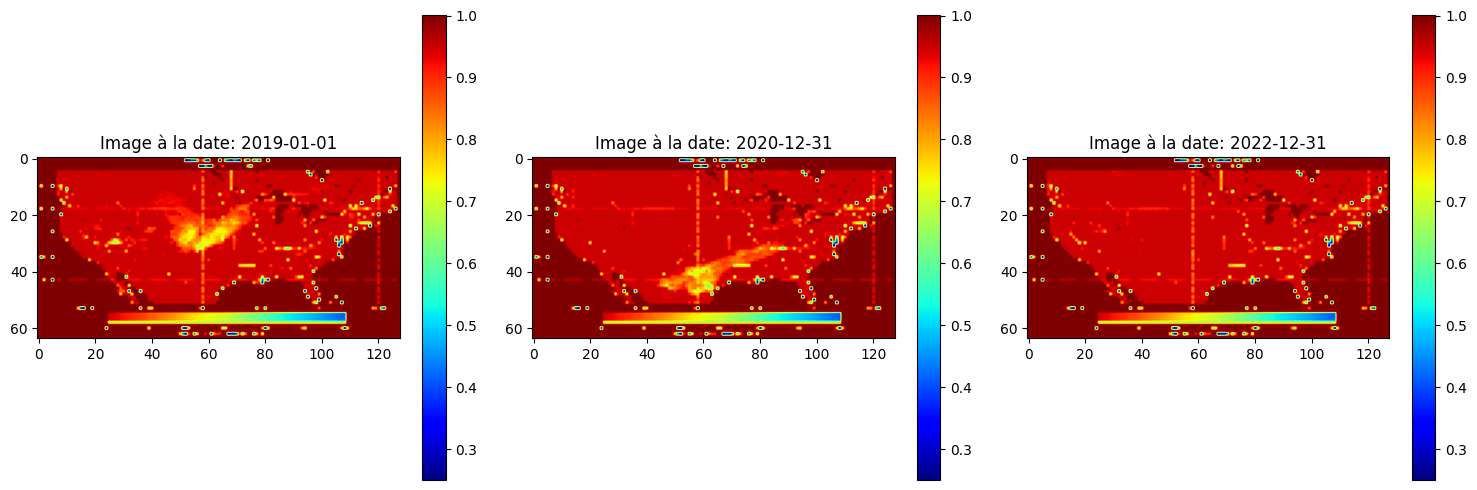

In [10]:
# Exécuter le chargement des données
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=730  # Environ 2 ans de données - ajustez selon vos besoins
)

# Afficher quelques informations
print(f"Nombre d'images chargées: {len(X_images)}")
print(f"Forme des images: {X_images.shape}")
print(f"Première date: {dates[0]}")
print(f"Dernière date: {dates[-1]}")

# Visualiser quelques exemples d'images
plt.figure(figsize=(15, 5))
for i in range(3):  # Afficher 3 images
    idx = i * (len(X_images) // 3)  # Prendre des images réparties uniformément
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images[idx, :, :, 0], cmap='jet')
    plt.title(f"Image à la date: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Libérer de la mémoire
optimize_memory()

Normalisation des données...
Scaler sauvegardé à: /kaggle/working/output2019-2024/visualization_outputUp_2019_2024/PotEvap/PotEvap.pkl
Valeur minimale après normalisation: 0.0
Valeur maximale après normalisation: 1.0000004768371582


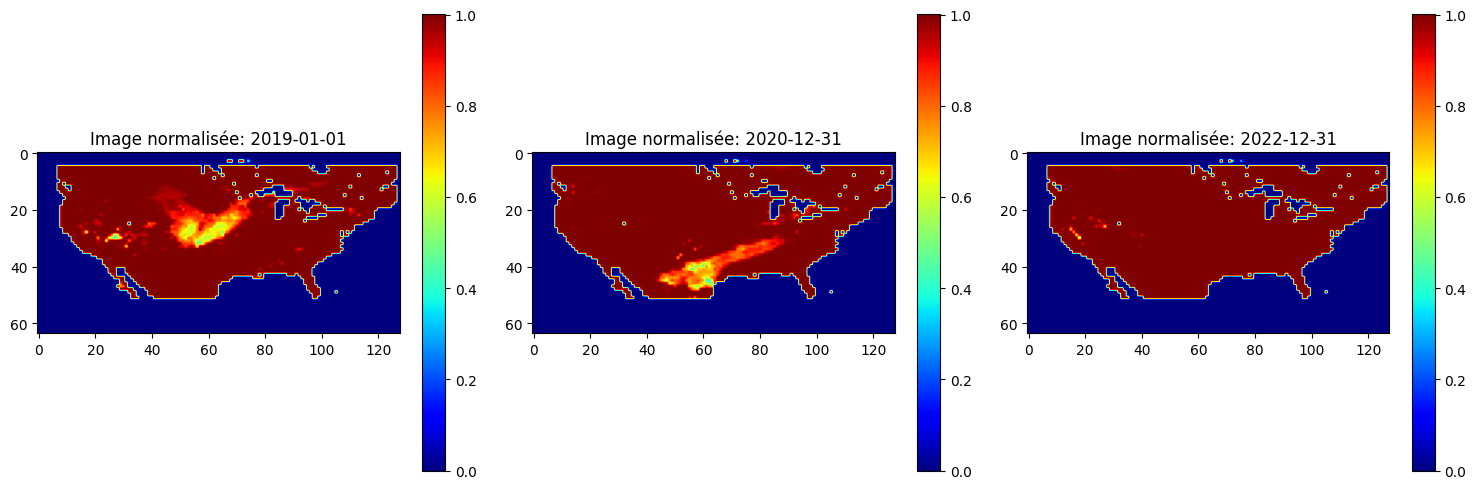

In [11]:
# Normalisation des données
print("Normalisation des données...")
scaler = MinMaxScaler(feature_range=(0, 1))

# Redimensionner pour appliquer le scaler
X_reshaped = X_images.reshape(X_images.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X_images_scaled = X_scaled.reshape(X_images.shape)

# Sauvegarde du scaler pour une utilisation ultérieure
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler sauvegardé à: {SCALER_SAVE_PATH}")

# Vérifier les valeurs min/max après normalisation
print(f"Valeur minimale après normalisation: {np.min(X_images_scaled)}")
print(f"Valeur maximale après normalisation: {np.max(X_images_scaled)}")

# Visualiser quelques exemples d'images normalisées
plt.figure(figsize=(15, 5))
for i in range(3):
    idx = i * (len(X_images) // 3)
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images_scaled[idx, :, :, 0], cmap='jet')
    plt.title(f"Image normalisée: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    # Vérifier si l'entrée est déjà un objet datetime
    if isinstance(date_obj, str):
        date = datetime.strptime(date_obj, '%Y-%m-%d')
    else:
        # Si c'est déjà un objet datetime, l'utiliser directement
        date = date_obj
    
    # Extraire les caractéristiques temporelles
    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday
    
    # Caractéristiques cycliques pour le mois et le jour de l'année
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return np.array([year, month, day, day_of_year, month_sin, month_cos, day_sin, day_cos])

def create_sequences_with_dates(data, dates, seq_length=30, pred_steps=7, batch_size=100):
    """
    Créer des séquences pour l'entraînement de séries temporelles avec caractéristiques de date
    Utilise le traitement par lots pour économiser la mémoire
    
    Args:
        data: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
        seq_length: Longueur de la séquence d'entrée
        pred_steps: Nombre de pas de temps à prédire
        batch_size: Taille des lots pour économiser la mémoire
        
    Returns:
        X: Séquences d'entrée
        y: Séquences cibles (à prédire)
        date_features: Caractéristiques de date pour chaque séquence
    """
    total_sequences = len(data) - seq_length - pred_steps + 1
    print(f"Création de {total_sequences} séquences au total...")
    
    # Préallouer les tableaux pour économiser de la mémoire
    X = np.zeros((total_sequences, seq_length, *data.shape[1:]), dtype=np.float32)
    y = np.zeros((total_sequences, pred_steps, *data.shape[1:]), dtype=np.float32)
    date_features = np.zeros((total_sequences, 8), dtype=np.float32)  # 8 caractéristiques de date
    
    # Traitement par lots pour économiser la mémoire
    for start_idx in range(0, total_sequences, batch_size):
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Traitement des séquences {start_idx} à {end_idx}...", end="\r")
        
        for i in range(start_idx, end_idx):
            # Séquence d'entrée: seq_length images consécutives
            X[i] = data[i:i+seq_length]
            # Séquence cible: pred_steps images suivantes
            y[i] = data[i+seq_length:i+seq_length+pred_steps]
            # Caractéristiques de date pour la dernière date de la séquence d'entrée
            last_date = dates[i+seq_length-1]
            date_features[i] = date_to_features(last_date)
        
        # Libérer la mémoire régulièrement
        if (end_idx - start_idx) % (batch_size * 5) == 0:
            gc.collect()
    
    print(f"\nNombre de séquences créées: {total_sequences}")
    
    
    return X, y, date_features



In [13]:
# Création des séquences avec caractéristiques de date
print("Création des séquences d'entraînement avec caractéristiques de date...")
X_seq, y_seq, date_features = create_sequences_with_dates(
    X_images_scaled, dates, SEQUENCE_LENGTH, PREDICTION_STEPS)

# Afficher les dimensions
print(f"Forme des séquences X: {X_seq.shape}")
print(f"Forme des séquences y: {y_seq.shape}")
print(f"Forme des caractéristiques de date: {date_features.shape}")

# Libérer de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()
optimize_memory()

# Division en ensembles d'entraînement et de validation (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]
date_features_train, date_features_val = date_features[:split_idx], date_features[split_idx:]

print(f"Ensemble d'entraînement: {X_train.shape[0]} séquences")
print(f"Ensemble de validation: {X_val.shape[0]} séquences")

# Libérer encore de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()

# Afficher quelques statistiques sur les caractéristiques de date
print("\nStatistiques des caractéristiques de date (ensemble d'entraînement):")
print(f"Années: min={date_features_train[:, 0].min()}, max={date_features_train[:, 0].max()}")
print(f"Mois: min={date_features_train[:, 1].min()}, max={date_features_train[:, 1].max()}")

Création des séquences d'entraînement avec caractéristiques de date...
Création de 2155 séquences au total...
Traitement des séquences 2100 à 2155...
Nombre de séquences créées: 2155
Forme des séquences X: (2155, 30, 64, 128, 1)
Forme des séquences y: (2155, 7, 64, 128, 1)
Forme des caractéristiques de date: (2155, 8)
Ensemble d'entraînement: 1724 séquences
Ensemble de validation: 431 séquences
Certaines variables à supprimer n'existent pas, poursuite du processus...

Statistiques des caractéristiques de date (ensemble d'entraînement):
Années: min=2019.0, max=2023.0
Mois: min=1.0, max=12.0


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, TimeDistributed, Concatenate, Dense, Reshape, UpSampling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda

In [15]:
def build_lighter_physics_inspired_model(seq_length, img_height, img_width, pred_steps, date_features_size):
    # Inputs
    input_sequence = Input(shape=(seq_length, img_height, img_width, 1))
    input_date = Input(shape=(date_features_size,))

    # Downsample input
    x = TimeDistributed(AveragePooling2D((2, 2)))(input_sequence)  # (None, seq_length, h/2, w/2, 1)

    # ConvLSTM layers
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(x)
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=False)(x)  # (None, h/2, w/2, 32)

    # Conv2D layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # (None, h/2, w/2, 32)

    # Process date features
    date_features = Dense(16, activation='relu')(input_date)
    date_features = Reshape((1, 1, 16))(date_features)
    
    # Tile date features using Lambda layer
    def tile_date_features(args):
        conv_output, date_features = args
        return tf.tile(date_features, [1, tf.shape(conv_output)[1], tf.shape(conv_output)[2], 1])
    
    date_features = Lambda(tile_date_features)([x, date_features])

    # Concatenate
    x = Concatenate(axis=-1)([x, date_features])  # (None, h/2, w/2, 48)

    # Final Conv2D - output pred_steps channels
    x = Conv2D(pred_steps, (3, 3), activation='linear', padding='same')(x)  # (None, h/2, w/2, pred_steps)

    # Reshape using Lambda layer
    def reshape_output(x):
        return tf.reshape(x, [-1, pred_steps, tf.shape(x)[1], tf.shape(x)[2], 1])
    
    x = Lambda(reshape_output)(x)

    # Upsample back to original size
    x = TimeDistributed(UpSampling2D((2, 2)))(x)  # (None, pred_steps, h, w, 1)

    return Model(inputs=[input_sequence, input_date], outputs=x)

In [16]:
# Build and compile
optimize_memory()
# PREDICTION_STEPS = y_train.shape[1]  # Should be 7 based on your error
# phydnet_model = build_lighter_physics_inspired_model(
#     SEQUENCE_LENGTH, 
#     IMG_HEIGHT, 
#     IMG_WIDTH, 
#     PREDICTION_STEPS, 
#     date_features_train.shape[1]
# )
with strategy.scope():
    # Build model inside strategy scope
    model = build_lighter_physics_inspired_model(
        SEQUENCE_LENGTH,
        IMG_HEIGHT,
        IMG_WIDTH,
        PREDICTION_STEPS,
        date_features_train.shape[1]
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{MODEL_SAVE_PATH}_PhyDNet.keras",
            save_best_only=True
        )
    ]
    
    # Train
    history = model.fit(
        [X_train, date_features_train], y_train,
        validation_data=([X_val, date_features_val], y_val),
        epochs=50,
        batch_size=16,
        callbacks=callbacks
    )

Epoch 1/50


E0000 00:00:1745771529.910798     963 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_6' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_6', 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_911/rep

108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - loss: 21062.2324 - mae: 86.3473 - val_loss: 944.8995 - val_mae: 11.9041
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 315ms/step - loss: 761.3008 - mae: 10.4669 - val_loss: 320.5284 - val_mae: 6.7608
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 316ms/step - loss: 263.3189 - mae: 6.1527 - val_loss: 143.8704 - val_mae: 4.5723
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 318ms/step - loss: 127.1116 - mae: 4.2219 - val_loss: 83.0150 - val_mae: 3.3214
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - loss: 75.8462 - mae: 3.2075 - val_loss: 54.6089 - val_mae: 2.7186
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - loss: 50.2195 - mae: 2.5900 - val_loss: 33.5949 - val_mae: 2.1235
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 320ms/step - loss: 30.5532 - mae: 2.0732 - val_loss: 21.1683 - val_mae: 1.8042
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 322ms/step - loss: 19.5793 - mae: 1.7526 - val_loss: 15.4588 - val_mae: 1.6907
Epoch 9/50
108/

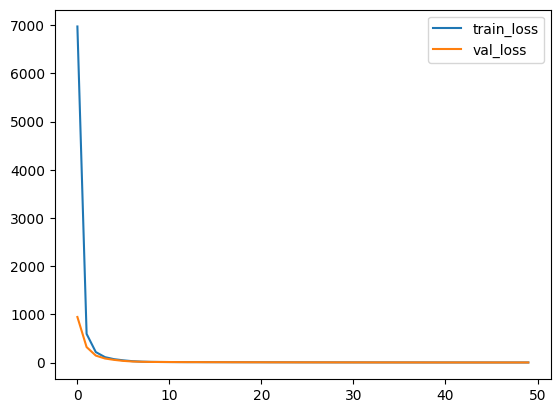

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [18]:
print(type(model))


<class 'keras.src.models.functional.Functional'>


In [19]:
loss, mae = model.evaluate([X_val, date_features_val], y_val, batch_size=8)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")

E0000 00:00:1745773294.913140     963 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_6' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_6', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.8728 - mae: 0.6158
Test loss: 0.8414283990859985
Test MAE: 0.6045047044754028


Évaluation du modèle ConvLSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.8690 - mae: 0.6138
Résultats de l'évaluation - ConvLSTM:
  Loss: 0.8317
  MAE: 0.5996
Modèle RNN sauvegardé à /kaggle/working/output2019-2024/visualization_outputUp_2019_2024/PotEvap/PotEvaprnn.keras


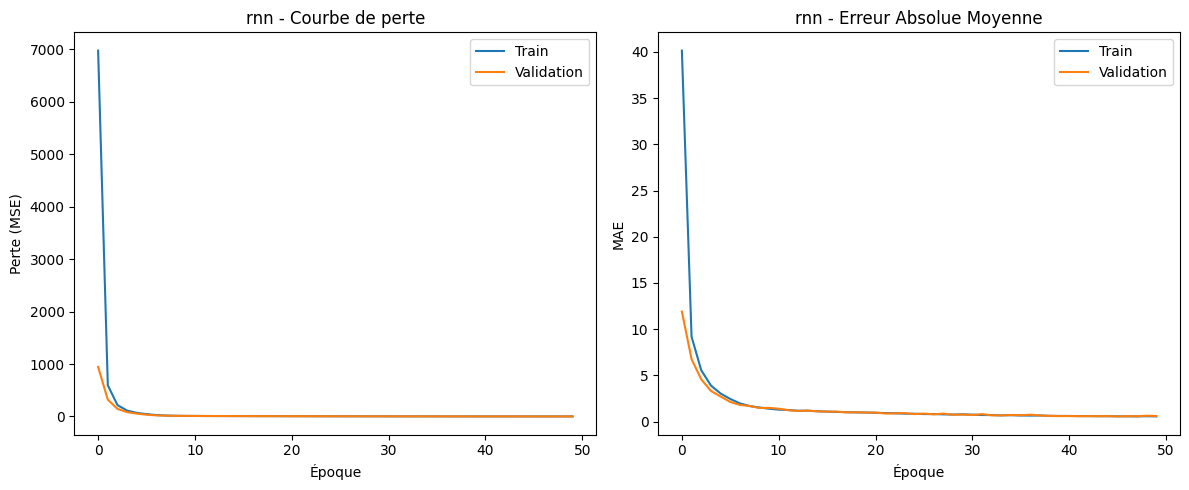

In [20]:
# Évaluation du modèle
print("Évaluation du modèle ConvLSTM...")
rnn = model.evaluate([X_val, date_features_val], y_val, batch_size=BATCH_SIZE, verbose=1)
print(f"Résultats de l'évaluation - ConvLSTM:")
print(f"  Loss: {rnn[0]:.4f}")
print(f"  MAE: {rnn[1]:.4f}")

# Sauvegarde du modèle
model.save(f"{MODEL_SAVE_PATH}rnn.keras")
print(f"Modèle RNN sauvegardé à {MODEL_SAVE_PATH}rnn.keras")

# Visualisation de l'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('rnn - Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('rnn - Erreur Absolue Moyenne')
plt.xlabel('Époque')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'rnn_training_curves.png'))
plt.show()

Calcul de l'exactitude du modèle RNN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step
Exactitude du modèle ConvLSTM (seuil d'erreur = 0.0487):
  2.96% des prédictions ont une erreur inférieure au seuil
  Pas de temps 1: 4.33%
  Pas de temps 2: 2.68%
  Pas de temps 3: 2.70%
  Pas de temps 4: 2.73%
  Pas de temps 5: 2.71%
  Pas de temps 6: 2.77%
  Pas de temps 7: 2.82%


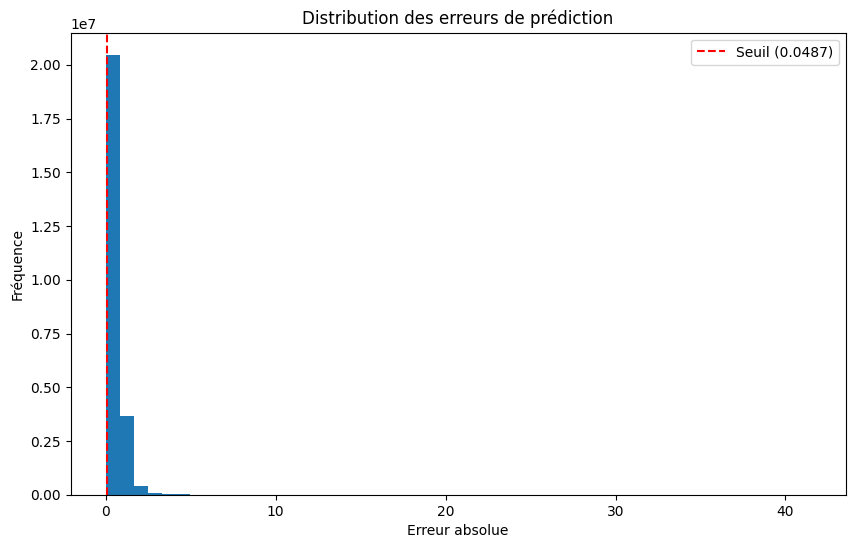

In [21]:
# Calcul d'une mesure d'exactitude pour le modèle
print("Calcul de l'exactitude du modèle RNN...")

# Faire des prédictions sur l'ensemble de validation
y_pred = model.predict([X_val, date_features_val], batch_size=BATCH_SIZE, verbose=1)

# Définir un seuil d'erreur acceptable (par exemple, 10% de l'écart-type des données)
threshold = 0.1 * np.std(y_val)

# Calculer l'erreur absolue entre les prédictions et les valeurs réelles
errors = np.abs(y_pred - y_val)

# Calculer le pourcentage de prédictions dont l'erreur est inférieure au seuil
accuracy = np.mean(errors < threshold) * 100

print(f"Exactitude du modèle ConvLSTM (seuil d'erreur = {threshold:.4f}):")
print(f"  {accuracy:.2f}% des prédictions ont une erreur inférieure au seuil")

# Vous pouvez également calculer l'exactitude par pas de temps de prédiction
for i in range(y_pred.shape[1]):
    step_accuracy = np.mean(errors[:, i] < threshold) * 100
    print(f"  Pas de temps {i+1}: {step_accuracy:.2f}%")

# Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
plt.hist(errors.flatten(), bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Seuil ({threshold:.4f})')
plt.title('Distribution des erreurs de prédiction')
plt.xlabel('Erreur absolue')
plt.ylabel('Fréquence')
plt.legend()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'convlstm_error_distribution.png'))
plt.show()